In [1]:
import os
import yaml
import random

import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt

np.set_printoptions(precision=4)

LABELS_PATH="labels.yaml"
IMAGES_BASE="/workspaces/motion/images/esp32/good"
BATCH_SIZE=10

2023-05-08 01:13:49.182801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 01:13:49.953207: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda-11.3/targets/x86_64-linux/lib
2023-05-08 01:13:49.953346: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidi

In [2]:
tf.config.list_physical_devices()

2023-05-08 01:13:50.909257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 01:13:50.920831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 01:13:50.921016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
with open(LABELS_PATH) as f:
    label_map = yaml.load(f, Loader=yaml.SafeLoader)["labels"]
reverse_label_map = {v:k for k,v in label_map.items()}

examples = []
examples_labels = []
for dir,_,files in os.walk(IMAGES_BASE):
    for file in files:
        examples.append(np.asarray(Image.open(os.path.join(dir, file)).point(lambda x: 255 if x>0 else 0), dtype=np.float32).reshape(29, 40, 1))
        examples_labels.append(label_map[os.path.basename(dir)])
examples_numpy = np.asarray(examples)
examples_labels_numpy = np.asanyarray(examples_labels)

ds = tf.data.Dataset.from_tensor_slices((examples_numpy, examples_labels_numpy))
ds = ds.shuffle(buffer_size=2000, seed=1).batch(BATCH_SIZE)
display(ds)

val_ds = ds.take(2)
test_ds = ds.skip(2).take(2)
train_ds = ds.skip(4)

for batch in train_ds:
    print(batch[1])

2023-05-08 01:13:50.990633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 01:13:50.993348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 01:13:50.993667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 01:13:50.993903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

<BatchDataset element_spec=(TensorSpec(shape=(None, 29, 40, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

tf.Tensor([6 1 3 4 7 3 2 3 4 0], shape=(10,), dtype=int64)
tf.Tensor([5 0 6 4 2 2 2 1 6 4], shape=(10,), dtype=int64)
tf.Tensor([1 6 1 4 2 5 3 2 6 6], shape=(10,), dtype=int64)
tf.Tensor([3 6 2 3 6 2 2 7 6 4], shape=(10,), dtype=int64)
tf.Tensor([6 6 5 4 4 2 6 3 5 7], shape=(10,), dtype=int64)
tf.Tensor([5 6 0 7 3 2 2 2 2 3], shape=(10,), dtype=int64)
tf.Tensor([7 7 7 6 2 2 1 4 7 2], shape=(10,), dtype=int64)
tf.Tensor([5 6 4 2 2 5 4 4 2 2], shape=(10,), dtype=int64)
tf.Tensor([2], shape=(1,), dtype=int64)


In [4]:
tf.debugging.set_log_device_placement(True)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(4, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(4, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
)

Epoch 1/30


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-05-08 01:13:52.470836: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-08 01:13:53.020437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-05-08 01:13:53.565516: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1c6109a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-08 01:13:53.565555: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti

9/9 [==============================] - 3s 25ms/step - loss: 103.9392 - accuracy: 0.2099 - val_loss: 26.1925 - val_accuracy: 0.4000
Epoch 2/30
9/9 [==============================] - 0s 6ms/step - loss: 44.7696 - accuracy: 0.4198 - val_loss: 7.5226 - val_accuracy: 0.7000
Epoch 3/30
9/9 [==============================] - 0s 6ms/step - loss: 42.6186 - accuracy: 0.4074 - val_loss: 2.4217 - val_accuracy: 0.8000
Epoch 4/30
9/9 [==============================] - 0s 6ms/step - loss: 20.6445 - accuracy: 0.3580 - val_loss: 1.5034 - val_accuracy: 0.9000
Epoch 5/30
9/9 [==============================] - 0s 6ms/step - loss: 11.7005 - accuracy: 0.6049 - val_loss: 1.1634 - val_accuracy: 0.8000
Epoch 6/30
9/9 [==============================] - 0s 6ms/step - loss: 9.8152 - accuracy: 0.5926 - val_loss: 0.2113 - val_accuracy: 0.9000
Epoch 7/30
9/9 [==============================] - 0s 6ms/step - loss: 9.8112 - accuracy: 0.6790 - val_loss: 0.1312 - val_accuracy: 0.9500
Epoch 8/30
9/9 [=====================

In [5]:
b = next(iter(test_ds))
img_array = b[0][0]
print(reverse_label_map[b[1][0].numpy()])
array_shaped = img_array.numpy().reshape(29,40)
print(array_shaped.shape)
display(Image.fromarray(array_shaped*255).convert("RGB"))
print(np.expand_dims(np.squeeze(img_array), axis=0).shape)
r = model.predict(np.expand_dims(np.squeeze(img_array), axis=0))
print([f"{i:.4f}" for i in r[0]])
print(np.max(r))
raw_pred = tf.argmax(r, 1).numpy()[0]
print(reverse_label_map[raw_pred])

gonadium
(29, 40)


(1, 29, 40)
1/1 [==============================] - 0s 91ms/step
['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.0000', '0.0000']
1.0
gonadium


1/1 [==============================] - 0s 20ms/step


Text(0.5, 1.0, 'Confusion Matrix')

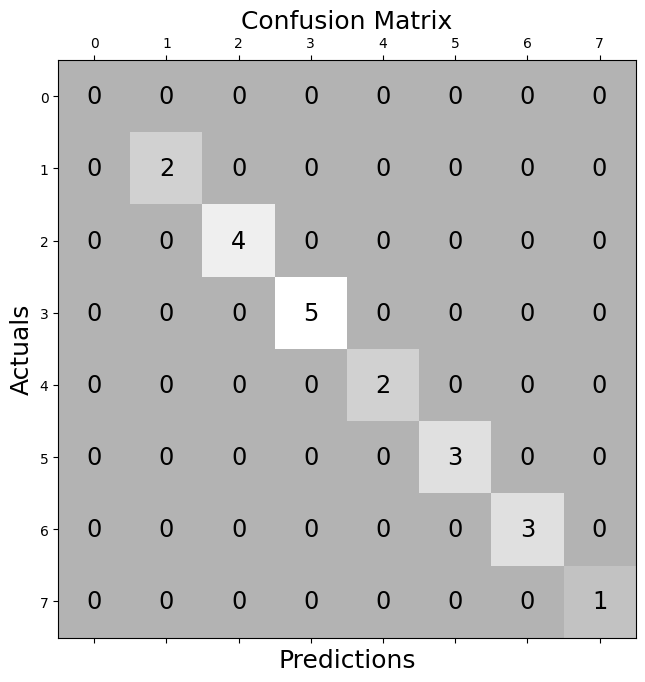

In [6]:
real_classes = []
pred_classes = []

for batch in test_ds:
    preds = model.predict(batch)
    pred_classes.extend(tf.argmax(preds, 1).numpy())
    real_classes.extend(batch[1].numpy())

conf_matrix = tf.math.confusion_matrix(real_classes, pred_classes)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.gray, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j].numpy(), va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)

In [7]:
model.save("output")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2c5c183d90>, 139830793421888), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2c5c140610>, 139829037281136), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2c5c15b4f0>, 139829036856224), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2c5c106550>, 139829036856144), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1120, 128),

INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets
